In [1]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table, join, vstack
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gala.coordinates as gc
from pyia import GaiaData

In [2]:
xmatch = Table.read('/Users/adrian/data/gaiadr2_allStar-t9-l31c-58158.fits')
xmatch.rename_column('apstar_id', 'APSTAR_ID')

In [3]:
apogee = Table.read('/Users/adrian/data/APOGEE_DR15beta/allStar-t9-l31c-58158.fits')

In [4]:
stream_mask = (apogee['APOGEE2_TARGET1'] & (2**18 + 2**19)) != 0
stream_mask.sum()

1035

In [83]:
apogee_gaia = join(apogee[stream_mask], xmatch, keys='APSTAR_ID')
ndim_cols = [x for x in apogee_gaia.columns if apogee_gaia[x].ndim == 1]
apogee_gaia = apogee_gaia[ndim_cols]

# select distance stuff
apogee_gaia = apogee_gaia[(apogee_gaia['parallax'] < 1.) | ((apogee_gaia['parallax'] - apogee_gaia['parallax_error']) < 1.)]

g = GaiaData(apogee_gaia)
len(g)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


620

In [84]:
np.unique(apogee_gaia['FIELD'])

GD1-1
GD1-2
GD1-3
GD1-4
GD1-5
M67
ORPHAN-1
ORPHAN-2
ORPHAN-3
ORPHAN-4
ORPHAN-5


In [85]:
gd1_mask = np.array(['GD1' in f for f in apogee_gaia['FIELD']])
orp_mask = np.array(['ORPHAN' in f for f in apogee_gaia['FIELD']])
pal5_mask = np.array(['PAL5' in f for f in apogee_gaia['FIELD']])
tri_mask = np.array(['TRIAND' in f for f in apogee_gaia['FIELD']])

gd1_mask.sum(), orp_mask.sum(), pal5_mask.sum(), tri_mask.sum()

(215, 190, 74, 15)

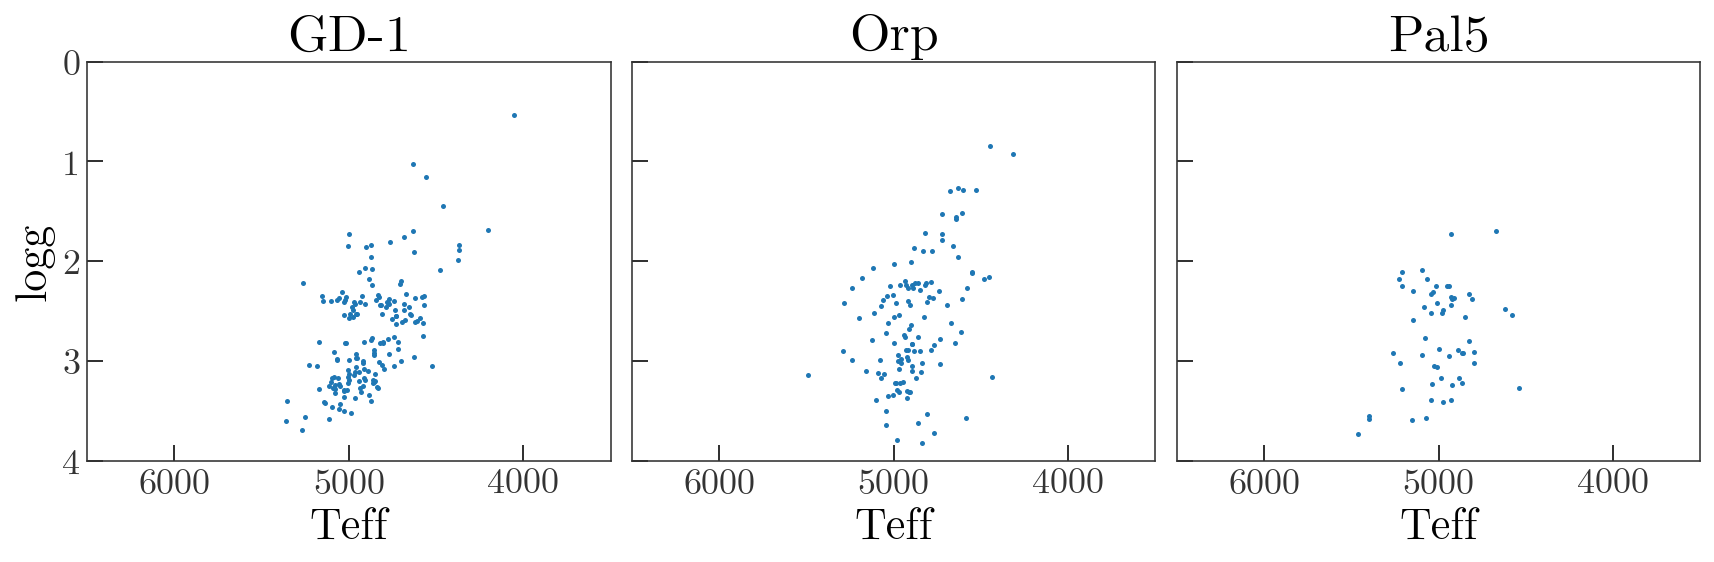

In [86]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for i, name, mask in zip(range(3), 
                         ['GD-1', 'Orp', 'Pal5'],
                         [gd1_mask, orp_mask, pal5_mask]):
    ax = axes.flat[i]
    ax.plot(apogee_gaia['TEFF'][mask], apogee_gaia['LOGG'][mask], 
            marker='.', linestyle='none')
    ax.set_title(name)
    ax.set_xlabel('Teff')

ax.set_xlim(6500, 3500)
ax.set_ylim(4, 0)
axes[0].set_ylabel('logg')

fig.tight_layout()

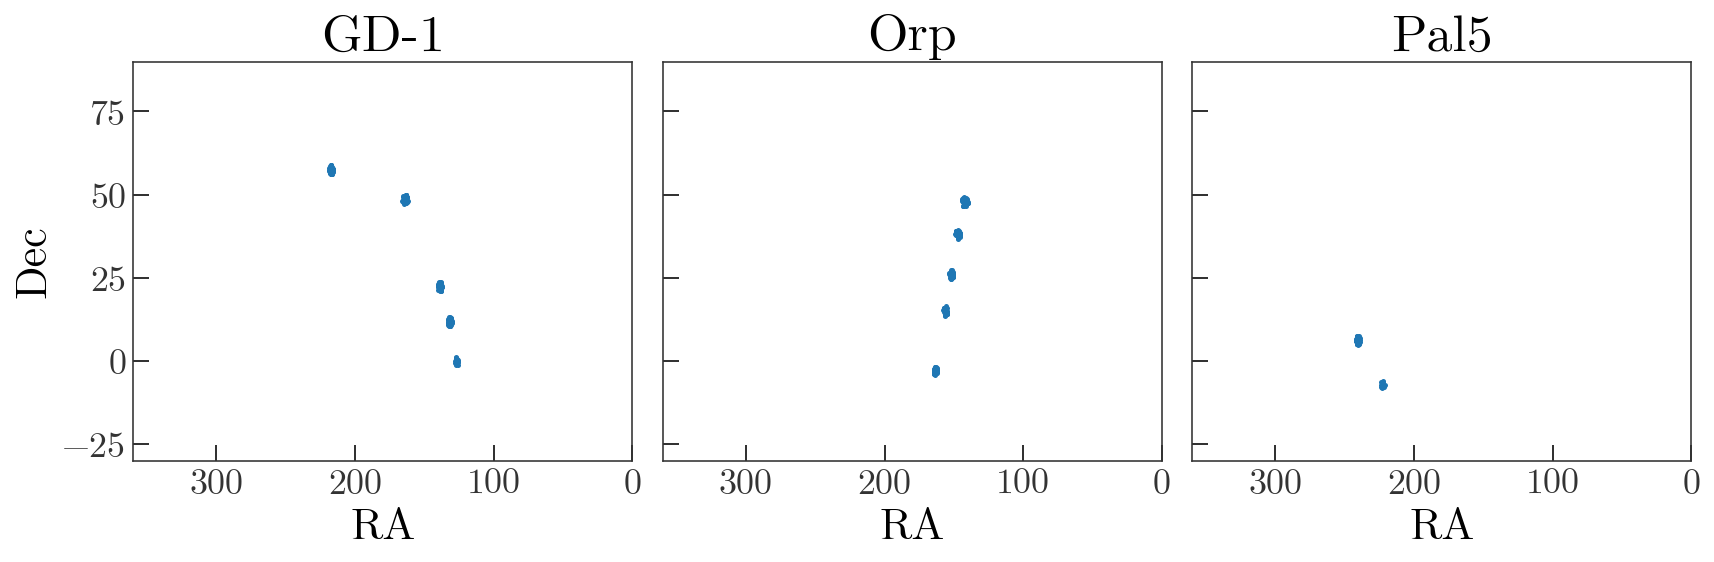

In [87]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for i, name, mask in zip(range(3), 
                         ['GD-1', 'Orp', 'Pal5'],
                         [gd1_mask, orp_mask, pal5_mask]):
    ax = axes.flat[i]
    ax.plot(apogee_gaia['RA'][mask], apogee_gaia['DEC'][mask], 
            marker='.', linestyle='none')
    ax.set_title(name)
    ax.set_xlabel('RA')

fig.tight_layout()
ax.set_xlim(360, 0)
ax.set_ylim(-30, 90)
axes[0].set_ylabel('Dec')

fig.tight_layout()

In [89]:
def reflex(c):
    c = coord.SkyCoord(c)
    v_sun = coord.Galactocentric.galcen_v_sun
    observed = c.transform_to(coord.Galactic)
    rep = observed.cartesian.without_differentials()
    rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
    new_c = coord.Galactic(rep).transform_to(c.frame)
    return new_c

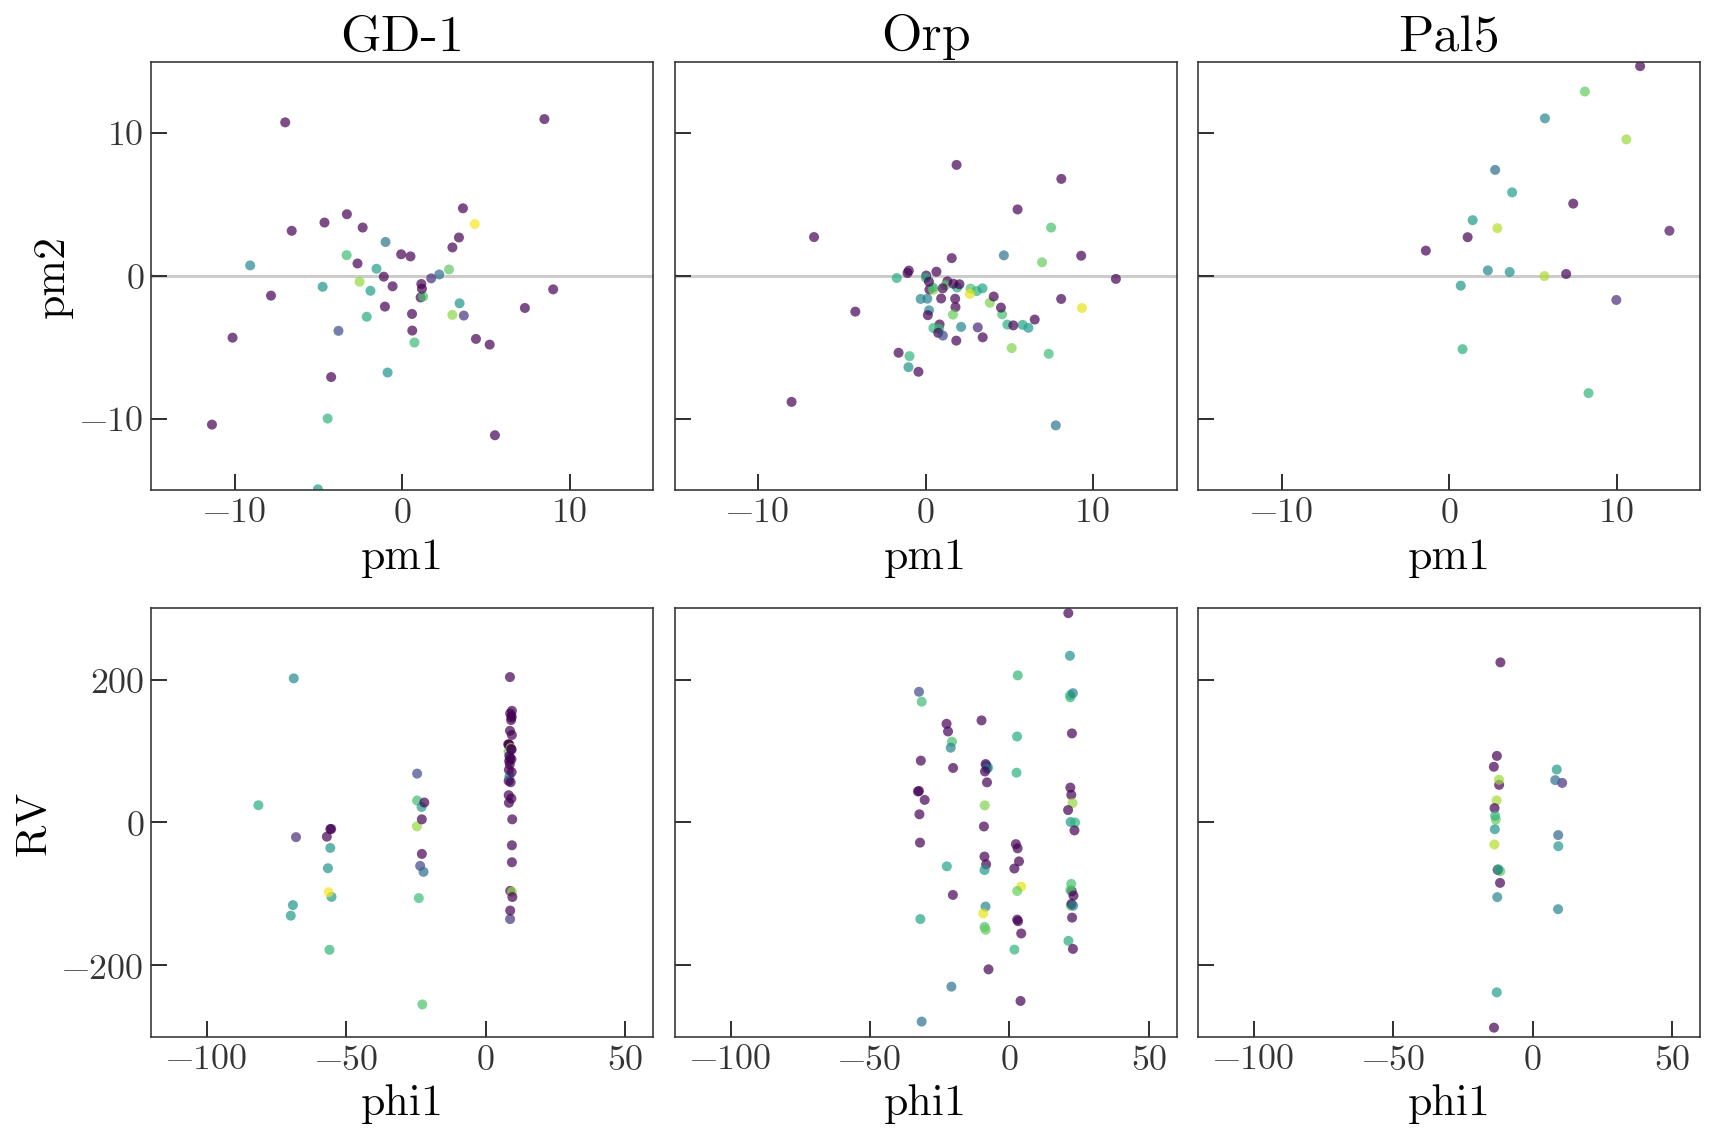

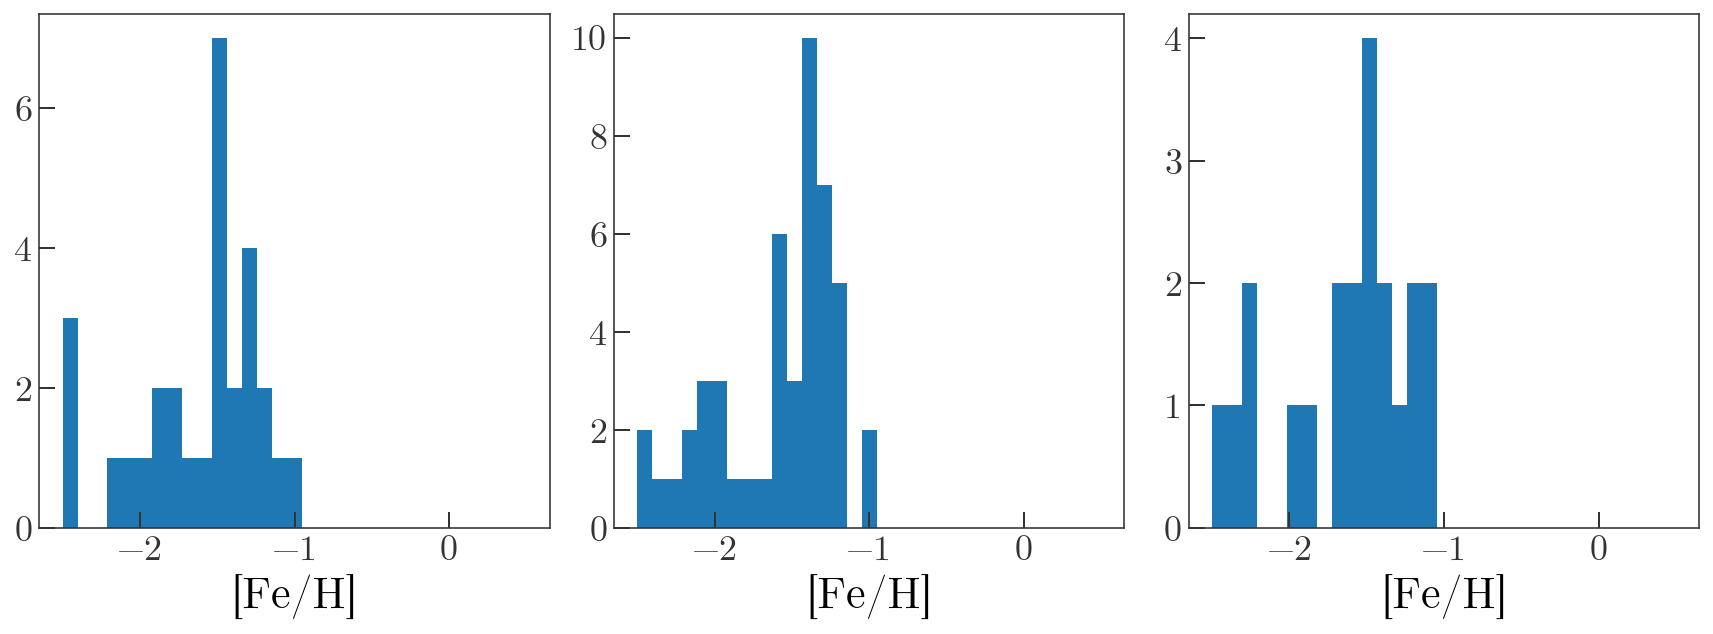

In [110]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex='row', sharey='row')
fig2, axes2 = plt.subplots(1, 3, figsize=(12, 4.5), sharex=True)

for line in zip(range(3), 
                ['GD-1', 'Orp', 'Pal5'],
                [gd1_mask, orp_mask, pal5_mask],
                [gc.GD1(), gc.Orphan(), gc.Pal5()],
                [8.*u.kpc, 30*u.kpc, 22*u.kpc]):
    i, name, mask, frame, dist = line
    
    lon, lat, _ = frame.get_representation_component_names().keys()
    
    stream_g = g[mask & np.array(g.FE_H < -1.)]
    c = coord.SkyCoord(ra=stream_g.ra, 
                       dec=stream_g.dec,
                       distance=np.ones(len(stream_g)) * dist,
                       pm_ra_cosdec=stream_g.pmra,
                       pm_dec=stream_g.pmdec,
                       radial_velocity=np.array(stream_g.VHELIO_AVG)*u.km/u.s)
    c = reflex(c.transform_to(frame))
    pm1 = getattr(c, 'pm_{0}_cos{1}'.format(lon, lat)).to(u.mas/u.yr)
    pm2 = getattr(c, 'pm_{0}'.format(lat)).to(u.mas/u.yr)
    
    # top row
    ax = axes[0, i]
    ax.scatter(pm1, pm2,
               c=stream_g.FE_H, vmin=-2., vmax=-1,
               marker='o', alpha=0.7, linewidth=0)
    ax.set_title(name)
    ax.axhline(0, zorder=-100, color='#cccccc')
    ax.set_xlabel('pm1')
    
    # bottom row
    ax = axes[1, i]
    ax.scatter(getattr(c, lon).wrap_at(180*u.deg),
               c.radial_velocity.to(u.km/u.s),
               c=stream_g.FE_H, vmin=-2., vmax=-1,
               marker='o', alpha=0.7, linewidth=0)
    ax.set_xlabel('phi1')
    
    # metallicity
    axes2[i].hist(stream_g.FE_H, bins=np.linspace(-2.5, 0.5, 32));
    axes2[i].set_xlabel('[Fe/H]')

fig.tight_layout()
axes[0, 0].set_xlim(-15, 15)
axes[0, 0].set_ylim(-15, 15)
axes[1, 0].set_xlim(-120, 60)
axes[1, 0].set_ylim(-300, 300)
axes[0, 0].set_ylabel('pm2')
axes[1, 0].set_ylabel('RV')

fig.tight_layout()
fig2.tight_layout()